In [3]:
from IPython.lib.deepreload import reload
%load_ext autoreload
%autoreload 2

import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings 

import tensorflow as tf
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" #If the line below doesn't work, uncomment this line (make sure to comment the line below); it should help.
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, Layer
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

import h5py
import cell_data
import glob

files = list(glob.glob("data/ttbar-test/train-*.h5"))
print(isinstance(files, list))


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
True


In [33]:
cells_et, _, _, label_et = cell_data.get_data(files,
                                                         labelkey="MET_Calo_pt")
_, cells_ex, _, label_ex = cell_data.get_data(files,
                                                         labelkey="MET_Calo_px")

_,_, cells_ey, label_ey = cell_data.get_data(files,
                                                         labelkey="MET_Calo_py")

def fletten(data):
    return data.reshape(-1,data.shape[1]*data.shape[2])

#cells_exy = np.concatenate([cells_ex, cells_ey], axis=0)
#label_exy = np.concatenate([label_ex, label_ey], axis=0)


## Load trained model from wandb  

In [41]:
import wandb

dic_models = {}
run = wandb.init()
artifact = run.use_artifact('ablet/model-registry/met-nn:v0', type='model')
model_dir = artifact.download()
dic_models['Raw']  = keras.models.load_model(model_dir+"/models/met_nn")

artifact = run.use_artifact('ablet/model-registry/met-nn:v1', type='model')
model_dir = artifact.download()
dic_models['Scaled'] = keras.models.load_model(model_dir+"/models/met_nn")


artifact_exy = run.use_artifact('ablet/model-registry/met-nn-exy:v0', type='model')
model_exy_dir = artifact_exy.download()

dic_models['met_x'] = keras.models.load_model(model_exy_dir+"/models/met-nn-exy")
dic_models['met_y'] = keras.models.load_model(model_exy_dir+"/models/met-nn-exy")

#artifact_exy_abpe = run.use_artifact('ablet/model-registry/met-nn-exy:v1', type='model')
model_exy_abpe_dir = "train_nn_exy/met-nn-exy.h5"  # artifact_exy_abpe.download()

dic_models['met_x_abpe'] = keras.models.load_model(model_exy_abpe_dir, compile=False)
dic_models['met_y_abpe'] = keras.models.load_model(model_exy_abpe_dir, compile=False)

wandb:   5 of 5 files downloaded.  
wandb:   5 of 5 files downloaded.  
wandb:   5 of 5 files downloaded.  


## test model

In [42]:
def test_model(model, test_data):
    return model(test_data).numpy()

dic_data = {'Raw':cells_et,
            'Scaled': cells_et*0.1,
           'met_x':cells_ex,
           'met_y':cells_ey,
           'met_x_abpe':cells_ex,
           'met_y_abpe':cells_ey}
dic_label = {'Raw':label_et,
            'Scaled': label_et,
           'met_x':label_ex,
            'met_y':label_ey,
            'met_x_abpe':label_ex,
            'met_y_abpe':label_ey}

results = {}
for key, model in dic_models.items():
    results[key] = test_model(model, dic_data[key])
    print(key)
 

Raw
Scaled
met_x
met_y
met_x_abpe
met_y_abpe


## plots

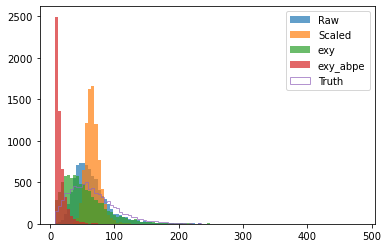

In [43]:
results['met_xy'] = np.sqrt(results['met_x']**2 + results['met_y']**2)
results['met_xy_abpe'] = np.sqrt(results['met_x_abpe']**2 + results['met_y_abpe']**2)


_,bins,_ = plt.hist(results['Raw'], bins=100, alpha=0.7, label="Raw")
_ = plt.hist(results['Scaled'], bins=bins,alpha=0.7, label="Scaled")
_ = plt.hist(results['met_xy'], bins=bins,alpha=0.7, label="exy")
_ = plt.hist(results['met_xy_abpe'], bins=bins, alpha=0.7, label="exy_abpe")
_ = plt.hist(label_et, bins=bins,alpha=0.7,histtype='step', label="Truth")
plt.legend()

## Scores

In [44]:
print(f"Raw: {r2_score(label_et, results['Raw'])}")
print(f"Scaled: {r2_score(label_et, results['Scaled'])}")
print(f"met_x: {r2_score(label_ex, results['met_x'])}")
print(f"met_y: {r2_score(label_ey, results['met_y'])}")
print(f"met_xy: {r2_score(label_et, results['met_xy'])}")


Raw: 0.27928022428677757
Scaled: 0.08209962035463991
met_x: 0.669958383569003
met_y: 0.6864991792410586
met_xy: 0.36423064251326953


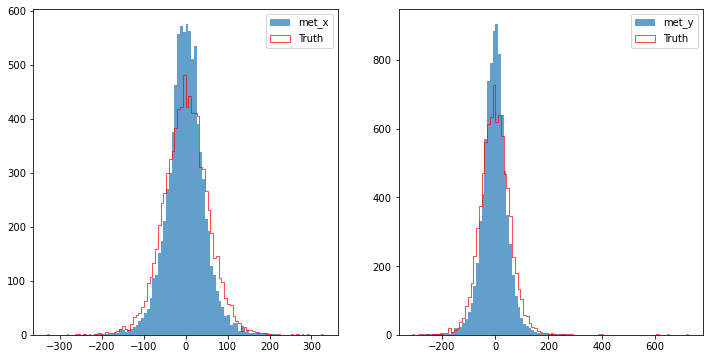

In [45]:
fig, axes = plt.subplots(1,2, figsize=(12,6))
for key in ['met_x', 'met_y']:
    ax = axes[0] if key=='met_x' else axes[1]
    _,bins,_ = ax.hist(results[key], bins=100, alpha=0.7, label=key)
    _ = ax.hist(dic_label[key], bins=bins,alpha=0.7,color='red',histtype='step', label="Truth")
    ax.legend()


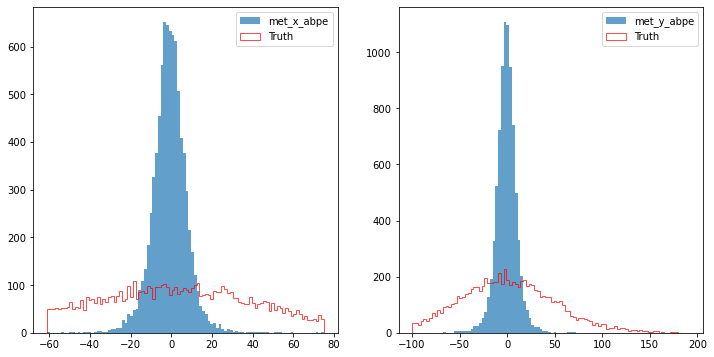

In [46]:
fig, axes = plt.subplots(1,2, figsize=(12,6))
for key in ['met_x_abpe', 'met_y_abpe']:
    ax = axes[0] if key=='met_x_abpe' else axes[1]
    _,bins,_ = ax.hist(results[key], bins=100, alpha=0.7, label=key)
    _ = ax.hist(dic_label[key], bins=bins,alpha=0.7,color='red',histtype='step', label="Truth")
    ax.legend()